# Lab1 — Part 2: Training on MNIST

**Course**: Deep Learning for Image Analysis

**Class**: M2 IASD App  

**Professor**: Mehyar MLAWEH

---

In this part, we move from a **toy dataset** to a **real image dataset**.  
We will train a neural network on **MNIST**, **without using CNNs**.

The goal is to understand **why CNNs are needed**, not to use them yet.


## Learning objectives

After this part, you should understand:
- How images are represented as **vectors**
- How a neural network processes image data
- How multi-class classification works
- Why fully-connected networks are **not optimal** for vision tasks


In [70]:
%pip install torchvision


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 0) Environment setup

Make sure you are using **GPU**:
- Runtime → Change runtime type → GPU


In [71]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
print("Using device:", device)


Using device: mps


## 1) Imports


In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms


## 2) The MNIST dataset

MNIST contains **handwritten digit images**:
- Image size: **28 × 28**
- Number of channels: **1 (grayscale)**
- Number of classes: **10** (digits 0–9)

Each image is originally a **2D grid of pixels**, but a fully-connected network
expects a **vector** as input.

https://www.youtube.com/watch?v=SrT6QkQUH4Q

### 🔍 Question (conceptual)

- How many pixels does one MNIST image contain?
> One image contains $\texttt{length} \times \texttt{height} = 28 \times 28 = 784$ pixels.

- What will be the size of the input vector after flattening?
> The input vector will have size $\texttt{length} \times \texttt{height} \times \texttt{num\_channels} = 784$.


In [73]:
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

len(train_dataset), len(test_dataset)

(60000, 10000)

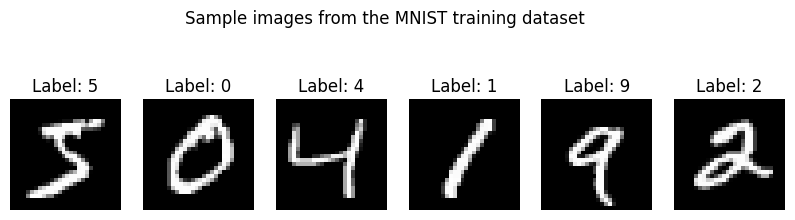

In [74]:

num_images = 6

plt.figure(figsize=(10, 3))

for i in range(num_images):
    image, label = train_dataset[i]

    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.suptitle("Sample images from the MNIST training dataset")
plt.show()


## 3) DataLoader and mini-batches

We use **mini-batches** to train efficiently.

⚠️ Choosing the batch size is a trade-off between speed and memory.


In [75]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## 4) Model: Fully-connected neural network (MLP)

### Two experiments with the same model

In this part, we train **the same neural network (MLP)** on two versions of MNIST:

1. **Original MNIST** (centered digits)
2. **Transformed MNIST** (shifted and rotated digits)

#### Experiment 1: MNIST (baseline)

1. **Flatten** the image `(1, 28, 28)` → `(784,)`
2. Feed it to a standard MLP

Architecture:
- Input: 784
- Hidden layer: 256 neurons + ReLU
- Output: 10 neurons (one per class)

The output represents **class scores (logits)**.



In [76]:
class MLP_MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.net(x)

model = MLP_MNIST().to(device)
model


MLP_MNIST(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

### ✅ TODO — Understanding the model

1. How many parameters does this model have?
> Recall the formula to compute the number of parameters for a linear layer : $\texttt{input\_dim} \times \texttt{output\_dim} + \texttt{output\_dim}$.

> So, $\texttt{total\_parameters} = 784 \times 256 + 256 + 256 \times 10 + 10 = 203 530$


In [77]:
# Verification of the result
total_parameters = sum([layer.numel() for layer in model.parameters()])
total_parameters, [layer.numel() for layer in model.parameters()]

(203530, [200704, 256, 2560, 10])

2. Which layer contains most of the parameters?
Explain briefly.

> The first linear layer (labeled (1) in the architecture displayed when printing the model) contains most of the parameters : 200704 + 256 (for the biases) which is equal to 200960. It costs this much because the goal of this layer is to project the initial flattened vector into a latent space of dimension 256, that is a transformation is applied 256 times to each of the 784 input coordinate. The other linear layer only concentrates 2570 parameters in comparison. 


 **Loss function and optimizer**

This is a **multi-class classification** problem.

- We use `CrossEntropyLoss`
- It combines **Softmax + Negative Log-Likelihood**


In [78]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



**Training loop**

The training logic is **exactly the same** as before.
Only the data and the model changed.


In [79]:
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")


Epoch 1/3 - Loss: 0.3612
Epoch 2/3 - Loss: 0.1613
Epoch 3/3 - Loss: 0.1101


**Evaluation on the test set**

We compute the **classification accuracy**.


In [80]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
accuracy


0.9674

#### Experiment 2: Shifted and rotated MNIST

We now apply random shifts and rotations to the training images.

This breaks the assumption that digits are always centered and aligned.

The **model architecture remains exactly the same**.


In [81]:
transform_augmented = transforms.Compose([
    transforms.RandomAffine(
        degrees=50,
        translate=(0.2, 0.2)
    ),
    transforms.ToTensor()
])

train_dataset_aug = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform_augmented
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

len(train_dataset_aug), len(test_dataset)


(60000, 10000)

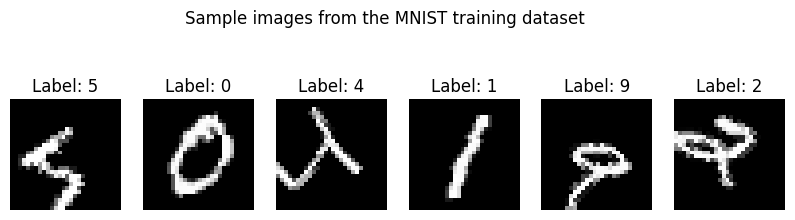

In [82]:

num_images = 6

plt.figure(figsize=(10, 3))

for i in range(num_images):
    image, label = train_dataset_aug[i]

    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.suptitle("Sample images from the MNIST training dataset")
plt.show()


Train the **same model** using the augmented training dataset.

Compare:
- Training loss
- Test accuracy

with the results obtained using original MNIST.


In [83]:
## TODO

# train
epochs = 3

# New model
model_aug = MLP_MNIST().to(device)

criterion_aug = nn.CrossEntropyLoss()
optimizer_aug = optim.Adam(model_aug.parameters(), lr=1e-3)

for epoch in range(epochs):
    model_aug.train()
    running_loss = 0.

    for images, labels in train_loader_aug:
        images, labels = images.to(device), labels.to(device)

        # Reinitialize the gradients to record new computations in the computational tree
        optimizer_aug.zero_grad()

        # Forward pass
        preds = model_aug(images)
        
        # Compute the cross entropy
        loss = criterion_aug(preds, labels)
        
        # Backpropagate
        loss.backward()
        
        # Gradient step
        optimizer_aug.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader_aug)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")


Epoch 1/3 - Loss: 1.2369
Epoch 2/3 - Loss: 0.7088
Epoch 3/3 - Loss: 0.5916


In [ ]:
## TODO

# evaluate
model_aug.eval()

correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        preds = model_aug(images)

        _, pred_labels = torch.max(preds, 1)

        total += labels.size(0)
        correct += (pred_labels == labels).sum().item()

accuracy = correct / total
accuracy

0.9077

> Results for a MLP trained on vanilla MNIST and evaluated on vanilla MNIST : `losses = [0.3612, 0.1613, 0.1101]`, `test_accuracy = 0.9674` (may variate if cells are executed again)

> Results for a MLP trained on shifted & rotated MNIST and evaluated on vanilla MNIST : `losses = [1.2369, 0.7088, 0.5916]`, `test_accuracy = 0.9077`.

> The results for the second MLP are less satisfactory than the first one both in terms of training loss and test accuracy. It means that the second model is less precise on the vanilla test set.

## 5) What do we observe? (Reflection)

 - Why does the same fully-connected model perform worse on shifted and rotated MNIST images compared to vanilla MNIST?

 > A fully-connected neural network is not trained to be prepared to shifts and rotations in data. Indeed, the input is a flattened vector in which we loose the idea of local structures so the learning is rigid, that is it learns patterns at fixed positions in the input data. For example, if a zero is drawn perfectly centered, a shift of 10 pixels to the right is going to activate different neurons in the MLP which may classify the input with the wrong class.

 - What limitation of fully-connected networks does this experiment reveal when dealing with images?

> This experiment reveals that a FC-NN is not relevant when manipulating pixels as we loose one of the most important feature in images : local structures. The network should be able to associate pixels that are close to each other and find patterns within group of pixels. Also, a problem we did not have to deal with here is to treat images with more than 1 channel. Indeed, for RGB images (or satellite images with more than 3 channels), it is almost impossible to agregate all the information contained in those channels in a 1-dimensional vector. Flattening may lead to an important loss of crucial information useful to discriminate two images in the context of classification, or in segmentation... Flattening would also be difficult to handle. Imagine an image of size (28,28) with 10 channels: the flattened input vector would be 10 times longer than the ones we were manipulating here.

- Based on these results, what properties should a better model for image data have?

> A better model for image data should be able to detect a pattern regardless of its absolute position in the grid. It should also have as inputs 3-dimensional tensors of shape `(input_channels, length, height)` (or 4D tensors including the batch size) in order to leverage informations stored in this specific disposition. It would be important to focus on local structures and extract low-level features (such as edges). Finally, it should remain scalable to higher resolution images without suffering from combinatorial explosions.

✍️ Write short answers (2–3 lines).


## 6) Looking ahead — why CNNs?

In the next assignment, we will replace this MLP with **Convolutional Neural Networks**.

CNNs:
- Exploit **spatial structure**
- Share parameters
- Achieve **much higher accuracy** on image tasks

👉 You should expect a **significant accuracy improvement** in the next assignment.
